# VOID HEDGE

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

Execute the cell below to load all necessary python packages and defines some helper functions

In [1]:
import urllib2
import urllib
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

def read_symbols(s_symbols_file):
    '''Read a list of symbols'''
    ls_symbols = []
    ffile = open(s_symbols_file, 'r')
    for line in ffile.readlines():
        str_line = str(line)
        if str_line.strip():
            ls_symbols.append(str_line.strip())
    ffile.close()
    return ls_symbols


# First steps: Get data from Yahoo and create time series Dataframe

Execute the cell below to pull historical stock data from Yahoo Finance.
By default we get data for all nasdaq stocks.
You can find the list of stocks to get data for in `.data/Lists/nasdaq_all.txt`.
If you want to work with a different list of stock symbols:
1. Create a new txt file
2. Modify the `symbolsPath` variable accordingly 

Be pacient. Downloading all the files may take a while :-).

In [10]:
'''
Pulling Yahoo CSV Data
'''

def get_yahoo_data(data_path, ls_symbols):
    '''Read data from Yahoo
    @data_path : string for where to place the output files
    @ls_symbols: list of symbols to read from yahoo
    '''
    # Create path if it doesn't exist
    if not (os.access(data_path, os.F_OK)):
        os.makedirs(data_path)

    ls_missed_syms = []
    # utils.clean_paths(data_path)

    _now = datetime.datetime.now()
    # Counts how many symbols we could not get
    miss_ctr = 0
    for symbol in tqdm(ls_symbols):
        # Preserve original symbol since it might
        # get manipulated if it starts with a "$"
        symbol_name = symbol
        if symbol[0] == '$':
            symbol = '^' + symbol[1:]

        symbol_data = list()
        # print "Getting {0}".format(symbol)

        try:
            params = urllib.urlencode ({'a':0, 'b':1, 'c':2000, 'd':_now.month-1, 'e':_now.day, 'f':_now.year, 's': symbol})
            url = "http://ichart.finance.yahoo.com/table.csv?%s" % params
            url_get = urllib2.urlopen(url)

            header = url_get.readline()
            symbol_data.append(url_get.readline())
            while (len(symbol_data[-1]) > 0):
                symbol_data.append(url_get.readline())

            # The last element is going to be the string of length zero.
            # We don't want to write that to file.
            symbol_data.pop(-1)
            # now writing data to file
            f = open(data_path + symbol_name + ".csv", 'w')

            # Writing the header
            f.write(header)

            while (len(symbol_data) > 0):
                f.write(symbol_data.pop(0))

            f.close()

        except urllib2.HTTPError:
            miss_ctr += 1
            ls_missed_syms.append(symbol_name)
        except urllib2.URLError:
            miss_ctr += 1
            ls_missed_syms.append(symbol_name)
            print "URL Error for stock: {0} at {1}".format(symbol_name, url)

    print "All done. Got {0} stocks. Could not get {1}".format(len(ls_symbols) - miss_ctr, miss_ctr)
    return ls_missed_syms


# Path to a list containing stock symbols we want to fetch historic stock data
symbolsPath ='data/Lists/nasdaq_all.txt'

# this is where the csv files will be saved
path='data/Yahoo/'

# read symbols from list and fetch data from yahoo finance
ls_symbols = read_symbols(symbolsPath)
print 'Fetching Data from Yahoo Finance. Be pacient ........'
get_yahoo_data(path, ls_symbols)



  0%|          | 0/3056 [00:00<?, ?it/s]

Fetching Data from Yahoo Finance. Be pacient ........


100%|██████████| 3056/3056 [13:53<00:00,  5.19it/s]

All done. Got 3056 stocks. Could not get 0


[]

In the following code cell we read historical stock data into a pandas time series dataframe. 
Reading in the data from the csv files may take a while. But after that things will speed up.
Panda dataframes are really fast.

Modify the `date` and `symbols` variables to your needs.

>**Note:** We use the SPY symbol as reference to construct the data frame with the proper time series. SPY was traded since the 90ies. We use SPY as reference to drop dates from our dataframe where the stock market was closed.

In [11]:
def symbol_to_path(symbol, base_dir='data/Yahoo'):
    '''Return CSV file path given ticker symbol.'''
    return os.path.join(base_dir, '{}.csv'.format(str(symbol)))


def get_data(symbols, dates):
    '''Read stock data (adjusted close) for given symbols from CSV files.'''
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in tqdm(symbols):
        # TODO: Read and join data for each symbol
        if os.path.isfile(symbol_to_path(symbol)) :
            df_temp = pd.read_csv(symbol_to_path(symbol), index_col = 'Date',
                              parse_dates = True, usecols = ['Date','Adj Close'],
                              na_values = ['nan'])
            df_temp = df_temp.rename(columns = {'Adj Close':symbol})
            df = df.join(df_temp)
            if symbol == 'SPY': #drop dates when SPY did not trade
        	    df = df.dropna(subset=['SPY'])
    # drop SPY column
    #df = df = df.drop('SPY', 1)
    print "All done."
    return df

# Define a date range
dates = pd.date_range('2016-01-01', '2016-12-30')

# Choose stock symbols to read
symbols = read_symbols('data/Lists/nasdaq_all.txt')

# Get stock data
df = get_data(symbols, dates)

100%|██████████| 3056/3056 [06:18<00:00,  4.35it/s]

All done.


# Exploratory Analysis

Now that we created our dataframe. Let's work with it.

In [18]:
'''
Uncomment some of the code below to see how to slice our data.
'''

# Slicing: row slicing for dates
# print df.ix['2016-10-01':'2016-11-28' ]

# Slicing: column slicing for symbols
# print df[['MDSY', 'GOOGL']]
# print df['GOOGL']
    
# Slicing: row and column
# print df.ix['2016-11-01':'2016-11-28', ['MDSY', 'GOOGL'] ]

Some helper functions you may want to use to explore the data. Feel free to add your own.

In [11]:
def normalize_data(df):
    """Normalize stock prices using the first row of the dataframe."""
    return df / df.ix[0, :]


def plot_data(df, title='Stock prices'):
    '''Plot stock prices'''
    ax = df.plot(title=title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.show()

def compute_daily_returns(df):
    """Compute and return the daily return values."""
    daily_returns = df.copy()  # copy given df to match size and column names
    daily_returns = (df / df.shift(1)) - 1
    daily_returns.ix[0, :] = 0  # set daily returns for row 0 to 0
    return daily_returns


def get_sharp_ratio(df):
    """Compute sharp ratio with a daily sample rate."""
    daily_returns = compute_daily_returns(df)
    sharp_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    return sharp_ratio


def cumulative_returns(df):
    cumulative_returns = df.copy()  # copy given df to match size and column names
    return cumulative_returns / cumulative_returns.ix[0, :] - 1


def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method='ffill', inplace=True)
    df_data.fillna(method='bfill', inplace=True)
    return df_data

# Indicators: Bollinger Bands

check out the [wiki](https://en.wikipedia.org/wiki/Bollinger_Bands) for more info on Bollinger Bands

At the end of the code we do a example visualization for Google stocks.
You should probably set the pdf flag for the bollinger_viz function to true so you can save it as pdf. Visibility is pretty bad if you look at it in the browser.

/Users/andreasdaiminger/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  app.launch_new_instance()
/Users/andreasdaiminger/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()


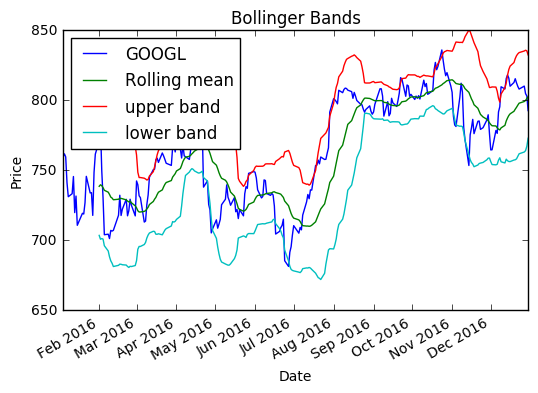

In [12]:
def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return pd.rolling_mean(values, window=window)


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return pd.rolling_std(values, window=window)


def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + rstd * 2
    lower_band = rm - rstd * 2
    return upper_band, lower_band



def bollinger_viz(df, window=20, pdf=False):
    """Creates Visualization of Bollinger Bands
       Set the pdf flag to true to save the viz as pdf
    """
    
    # Compute Bollinger Bands
    
    # 1. Compute rolling mean
    rm = get_rolling_mean(df, window=window)

    # 2. Compute rolling standard deviation
    rstd = get_rolling_std(df, window=window)

    # 3. Compute upper and lower bands
    upper_band, lower_band = get_bollinger_bands(rm, rstd)

    # Plot raw values, rolling mean and Bollinger Bands
    ax = df.plot(title="Bollinger Bands", label=df.name)
    rm.plot(label='Rolling mean', ax=ax)
    upper_band.plot(label='upper band', ax=ax)
    lower_band.plot(label='lower band', ax=ax)

    # mark specifix x-axis range
    # ax.axvspan('2016-11-21', '2016-12-01', color='red', alpha=0.5)

    # Add axis labels and legend
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')

    # Check wether to show the figure or save as pdf
    if pdf:
        plt.savefig('./information/Bollinger_crashers/' +
                    df.name + '_bollinger_viz.pdf', format='pdf')
        plt.close()
    else:
        plt.show()
        
bollinger_viz(df['GOOGL'], window=20)


# Get all 2Sigma Bollinger Crashers
In the code below we first get all bollinger crashers. That means all stocks that hit the lower bollinger band.
These stocks differ at least 2x Standard deviation from their 20 day rolling mean. This can be seen as an indicator for a potential buy.
If you like you can implement the same for stocks that crashed the upper bollinger band. They are potential stocks for shorting.

In [13]:
def is_bollinger_crasher(df):
    # Compute Bollinger Bands
    # 1. Compute rolling mean
    rm = get_rolling_mean(df, window=20)
    # 2. Compute rolling standard deviation
    rstd = get_rolling_std(df, window=20)

    # 3. Compute upper and lower bands
    upper_band, lower_band = get_bollinger_bands(rm, rstd)

    if df.get_value(-1) < lower_band.get_value(-1):
        return True
    else:
        return False
    

# get bollinger crashers
crashers_list = []
for symbol in df:
    if is_bollinger_crasher(df[symbol]):
        crashers_list.append(symbol)

# print list of bollinger crasher and save visualization           
print 'Bollinger Crashers:'
for e in crashers_list:
    bollinger_viz(df[e], window=20, pdf=True)
    print e

/Users/andreasdaiminger/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  app.launch_new_instance()
/Users/andreasdaiminger/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()


Bollinger Crashers:
ACIA
AXDX
AEGN
AGLE
AGRX
ALNY
ANTH
RKDA
ASCMA
BLRX
BLBD
BRID
BVSN
CEMP
CETV
CERU
CHKE
CNIT
CHSCP
CLNE
CLIR
CBLI
CFRX
CTRL
CORT
CORI
DFRG
TACO
DMPI
DXCM
DFBG
EVLMC
EBIX
LOCO
EMITF
ESBK
ECYT
ETRM
FAST
FATE
GSM
FMI
FRPH
FCEL
GHDX
GDEN
HLG
HRMNU
HMNY
HSON
RXDX
IDSA
INNL
ITEK
NTLA
STPP
ITRI
IVENC
MAYS
FSTR
LAKE
LVNTB
MCUR
MDGL
MGIC
MMYT
MRVL
MTBC
MNOV
NERV
MRTX
MOSY
NK
NEOS
NTAP
NWS
NWSA
OIIM
ZEUS
OPK
PNRA
FRSH
PCYG
PDVW
PNTR
PBPB
PSIX
PRAN
PRIM
BTEC
PVBC
PTCT
ROST
SNFCA
SBNYW
SIMO
SPU
SFM
SSNC
SBUX
SSKN
TTPH
XONE
TZOO
VALU
VRML
VISN
XOMA
